# Lab2:手写线性/激活/交叉熵算子+手写数字识别

### 基础知识：
知道矩阵、张量、激活、参数的概念，知道简单的python代码，一丢丢高中数学知识

### 目标

用四种角度理解矩阵乘法、激活函数和交叉熵损失设计的原理

用自己手写的线性层、激活函数、交叉熵损失，训练出一个准确率大于95%的手写数字识别模型

![](../.assets/custom_mlp_mnist.png)

### 如何学习

不重要的代码不需要看，只关注关键代码的填空改错即可

### 任务：理解并实现线性层

问题：经典的神经网络图（神经元和连接）和线性层有什么关系？

【等价关系】

![](../.assets/how_to_understand_mat_mul.jpg)

如何用四种方式对矩阵乘法进行理解？线性层、Transformer注意力、加权平均、LLMINT8外积分解

问题：线性层这种矩阵乘法的理解为什么成立

【因为矩阵分块乘法的性质】

问题：为什么行向量乘以矩阵等价于神经网络连接

提示：每行看作一个样本，每列是特征

【行向量和W第一列算出第一个神经元输出就理解了】

![](../.assets/matmul_and_connect.jpg)

问题：为什么pytorch当中都是激活在前

【因为人习惯从左到右，可以连续的((XW)W)，但是如果W在前就不舒服】

问题：如果X是更高维度，如何理解线性层

【最后一个维度看作样本，单独线性，最后按照原来的形状拼接】

问题：为什么pytorch当中把X的列数量叫做input_features, 输出的列数量叫做output_features

【因为代表输入输出样本的特征数】

问题：input_features和output_features和输入输出神经元的个数有什么关系

【相等的关系】

问题：把一部分w设为0为什么叫做剪枝

【因为w是边】

问题：为什么pytorch当中使用X @ W.T 而不是 X @ W 

【内存连续性】

问题：pytorch定义属性的时候，为什么要用nn.Parameter()

【否则不被视为可训练参数，不会放入state_dict，而测试中需要将标准模型的state_dict加载到自定义实现】

TODO：实现`mytorch\mytorch\mynn\mlp\linear.py`当中的三个TODO，其中初始化使用`nn.init.kaiming_uniform_(self.weight)`，详细推导见之后

In [ ]:
# 问题，什么是state_dict, 测试的逻辑是什么？
# 【state_dict记录了模型权重名称和具体权重。测试的逻辑是，尝试把官方模型加载到自己实现的模型，然后比较推理结果】

import torch
linaer_layer = torch.nn.Linear(3, 4)
for key, param in linaer_layer.state_dict().items():
    print(key, param.shape)
    
# 问题：state_dict的名称是如何确定的？
# 【模型的层的属性名嵌套确定的，假如模型model.layer1.layer2.weight可以访问一个权重，那么名称就是layer1.layer2.weight】

weight torch.Size([4, 3])
bias torch.Size([4])


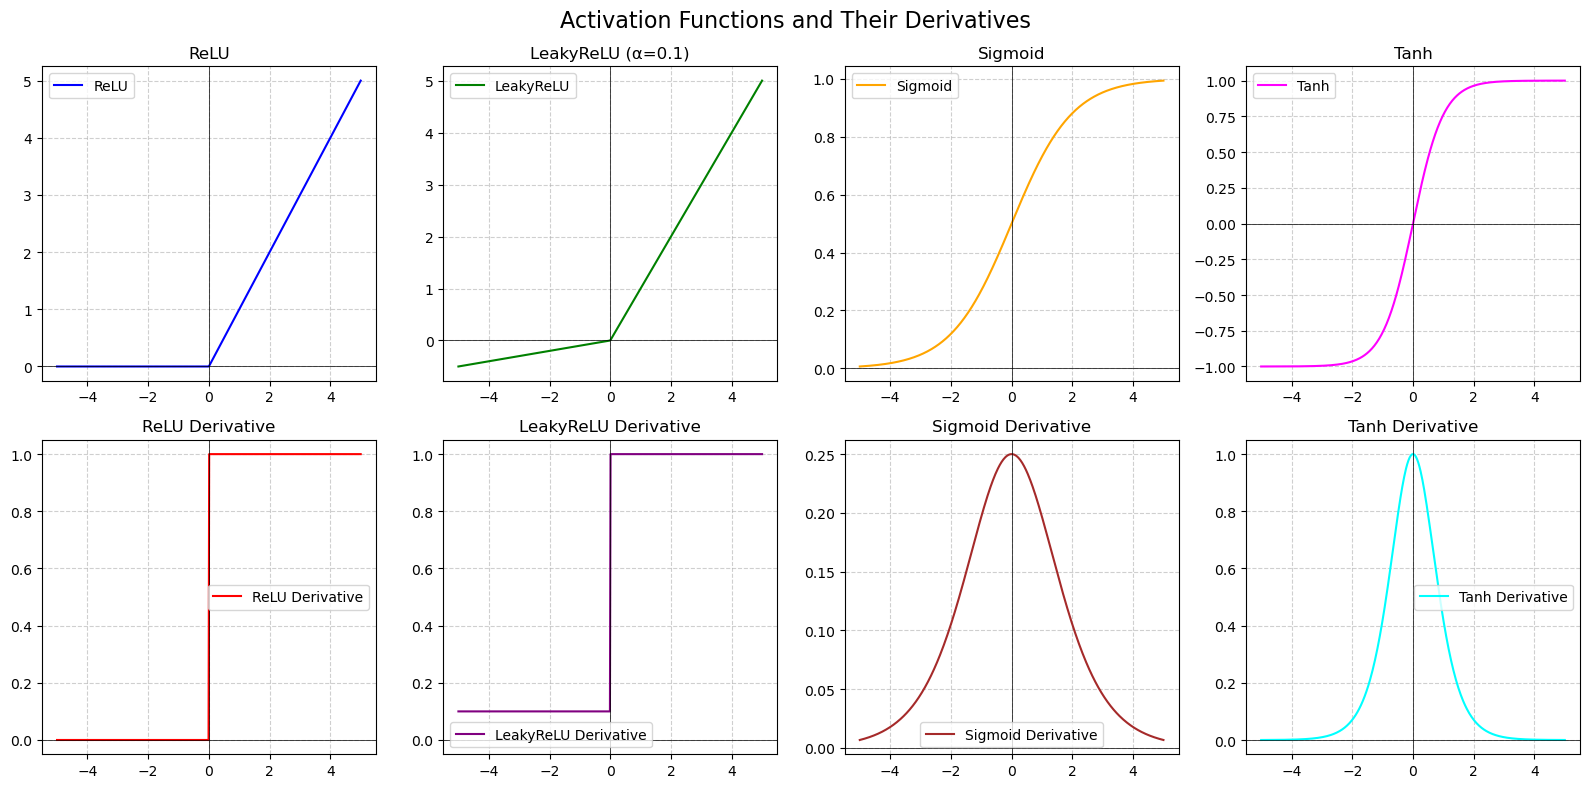

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 设置图像风格
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Activation Functions and Their Derivatives', fontsize=16)

# 定义输入范围
x = np.linspace(-5, 5, 500)

# ------------------------------
# 1. ReLU 及其导数
# ------------------------------
relu = np.maximum(0, x)
relu_grad = (x > 0).astype(float)

axes[0, 0].plot(x, relu, label='ReLU', color='blue')
axes[0, 0].set_title('ReLU')
axes[1, 0].plot(x, relu_grad, label='ReLU Derivative', color='red')
axes[1, 0].set_title('ReLU Derivative')

# ------------------------------
# 2. LeakyReLU 及其导数 (alpha=0.1)
# ------------------------------
alpha = 0.1
leaky_relu = np.where(x > 0, x, alpha * x)
leaky_relu_grad = np.where(x > 0, 1, alpha)

axes[0, 1].plot(x, leaky_relu, label='LeakyReLU', color='green')
axes[0, 1].set_title(f'LeakyReLU (α={alpha})')
axes[1, 1].plot(x, leaky_relu_grad, label='LeakyReLU Derivative', color='purple')
axes[1, 1].set_title('LeakyReLU Derivative')

# ------------------------------
# 3. Sigmoid 及其导数
# ------------------------------
sigmoid = 1 / (1 + np.exp(-x))
sigmoid_grad = sigmoid * (1 - sigmoid)

axes[0, 2].plot(x, sigmoid, label='Sigmoid', color='orange')
axes[0, 2].set_title('Sigmoid')
axes[1, 2].plot(x, sigmoid_grad, label='Sigmoid Derivative', color='brown')
axes[1, 2].set_title('Sigmoid Derivative')

# ------------------------------
# 4. Tanh 及其导数
# ------------------------------
tanh = np.tanh(x)
tanh_grad = 1 - tanh ** 2

axes[0, 3].plot(x, tanh, label='Tanh', color='magenta')
axes[0, 3].set_title('Tanh')
axes[1, 3].plot(x, tanh_grad, label='Tanh Derivative', color='cyan')
axes[1, 3].set_title('Tanh Derivative')

# 统一设置坐标轴和网格
for i in range(2):
    for j in range(4):
        axes[i, j].grid(True, linestyle='--', alpha=0.6)
        axes[i, j].axhline(0, color='black', linewidth=0.5)
        axes[i, j].axvline(0, color='black', linewidth=0.5)
        axes[i, j].legend()

plt.tight_layout()
plt.show()

### 任务：理解并手动实现激活函数

问题：只有线性层可以吗，所以呢

【不行，因为可以把W合并，所以要有非线性函数】

---

**1. ReLU (Rectified Linear Unit)**
• 函数：

  $$
  f(x) = \max(0, x)
  $$
• 导数：

  $$
  f'(x) = \begin{cases} 
  1 & \text{if } x > 0 \\
  0 & \text{otherwise}
  \end{cases}
  $$
• 特点：

  • 计算简单，缓解梯度消失问题（正区间梯度为 1）。

  • 缺点：负区间梯度为 0，可能导致“神经元死亡”。


---

**2. LeakyReLU (Leaky Rectified Linear Unit)**
• 函数（$\alpha$ 为小常数，如 0.1）：

  $$
  f(x) = \begin{cases} 
  x & \text{if } x > 0 \\
  \alpha x & \text{otherwise}
  \end{cases}
  $$
• 导数：

  $$
  f'(x) = \begin{cases} 
  1 & \text{if } x > 0 \\
  \alpha & \text{otherwise}
  \end{cases}
  $$
• 特点：

  • 解决 ReLU 的“神经元死亡”问题（负区间梯度为 $\alpha$）。

  • $\alpha$ 通常设为 0.01 或 0.1。


---

**3. Sigmoid**
• 函数：

  $$
  f(x) = \frac{1}{1 + e^{-x}}
  $$
• 导数：

  $$
  f'(x) = f(x) \cdot (1 - f(x))
  $$
• 特点：

  • 输出范围 $[0, 1]$，适合概率输出。

  • 缺点：梯度消失问题严重（当 $x \to \pm\infty$ 时，导数接近 0）。


---

**4. Tanh (Hyperbolic Tangent)**
• 函数：

  $$
  f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
  $$
• 导数：

  $$
  f'(x) = 1 - \tanh^2(x)
  $$
• 特点：

  • 输出范围 $[-1, 1]$，均值为 0，比 Sigmoid 更适合隐藏层。

  • 梯度消失问题仍存在（但比 Sigmoid 轻微）。


---

**5. Softmax**
• 函数（多分类输出层）：

  $$
  f(z_i) = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}
  $$
  • 其中 $K$ 是类别数，$z_i$ 是第 $i$ 个类别的 logits。

• 导数（对 $z_i$ 和 $z_j$ 的偏导）：

  $$
  \frac{\partial f(z_i)}{\partial z_j} = \begin{cases} 
  f(z_i) \cdot (1 - f(z_j)) & \text{if } i = j \\
  -f(z_i) \cdot f(z_j) & \text{if } i \neq j
  \end{cases}
  $$
• 特点：

  • 输出为概率分布（所有类别和为 1）。

  • 仅用于多分类输出层，不适用于隐藏层。



问题： 如何记住上面的激活函数公式？导数公式？

【答案：见的次数太多了很好记。导数不需要记住，需要的时候推导即可。】

问题：如何手动实现自定义梯度计算？复杂神经网络的梯度计算是如何进行的？

【答案：自定义backward函数，放在二值量化当中讲。复杂函数梯度由梯度算子实现计算】

如何理解tanh和sigmoid

【tanh类似于范围扩大一倍的sigmoid】

tanh的单调性如何理解，为什么叫做tanh

【负无穷大的时候，e^-x占主导，后面同理。因为具有sinh、cosh、tanh和sin、cos、tan有类似的公式，因为sinh是二分之分子，sinh奇函数，cosh偶函数】

如何利用类似于三角函数的性质推导tanh的导数

【把tanh换成sinh/cosh，由于sinhx导数是cosh，反之同，搞定】

![](../.assets/softmax_grad.jpg)

待会实现的softmax的步骤

【求e^, 求和，除以】

为什么softmax可以表示概率

【答案：1.数越大softmax越大，2.总和为1】

TODO：手动推导sigmoid和softmax的导数

问题：为什么softmax原始公式有点不稳定，要如何改进

【因为万一有一个数很大，可以通过除以e^最大数解决，此时分子为1，此时最大数为1，其他数为0】

问题：上述改进等价于什么

【等价于一开始所有数就减去最大值】

问题：张量如何求激活函数

【逐元素做，softmax需要考虑维度】

TODO: 完成`mytorch\mytorch\mynn\mlp`当中的relu、sigmoid、softmax、tanh算子

### 任务：理解并手动实现交叉熵损失

![](../.assets/how_to_understand_celoss.jpg)

问题：交叉熵损失为什么要这么设计

【预测越准确损失越小】

问题：交叉熵不会是负无穷吗

【softmax数值是稳定的，概率即使是10^-50，其实-log也不是很大】

TODO：完成`mytorch\mytorch\mynn\loss\`当中的交叉熵损失

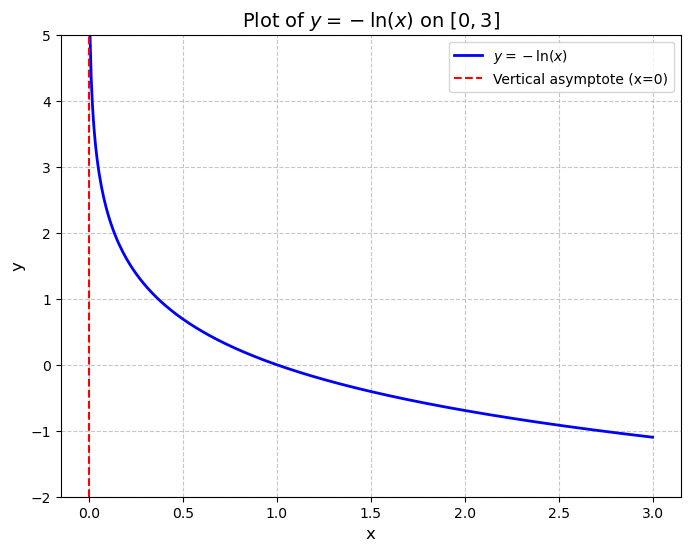

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 定义函数
def neg_log(x):
    return -np.log(x)  # 默认 np.log 是自然对数（ln）

# 生成 x 值（避免 x=0 和 x<0）
x = np.linspace(0.001, 3, 500)  # 从接近 0 开始，避免 log(0) 无定义
y = neg_log(x)

# 绘制图像
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=r"$y = -\ln(x)$", color="blue", linewidth=2)

# 设置坐标轴和标题
plt.title(r"Plot of $y = -\ln(x)$ on $[0, 3]$", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# 处理 x=0 的渐近行为
plt.axvline(x=0, color="red", linestyle="--", label="Vertical asymptote (x=0)")
plt.ylim(-2, 5)  # 限制 y 轴范围，避免图像过于陡峭

# 显示图例
plt.legend()
plt.show()

In [9]:
import torch

# 创建一个 3x4 的示例张量
tensor_2d = torch.tensor([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12]
])
print("原始张量:\n", tensor_2d)

row_index = torch.tensor([0,2])
col_index = torch.tensor([1, 3])
print(tensor_2d[row_index, col_index])

原始张量:
 tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]])
tensor([ 2, 12])


### 任务：用自己实现的线性层、交叉熵、训练模型

问题：训练简单模型的基本流程是什么

【很经典，不赘述】

TODO：完成`model\mnist\mlp`当中的代码，分别使用标准实现和自己的实现训练模型